In [1]:
import simpy

In [2]:
from metrics import MetricsCollector, MetricsMonitor
from simulation_actors import Submitter, JobScheduler, PoolManager
from simulation_components import JobQueue, InstancePool, EC2Service

In [3]:
# def plot_metrics(metrics: MetricsCollector):
#     """
#     Generates and displays plots from the collected simulation metrics.
#     """
#     print("\n--- Generating plots ---")
#     fig, axs = plt.subplots(4, 1, figsize=(12, 20), sharex=True)
#     fig.suptitle("Job Execution System Simulation Results", fontsize=16)

#     # Plot 1: Queue Length Over Time
#     ax1 = axs[0]
#     for color, data in metrics.queue_lengths_by_color.items():
#         if data:
#             times, lengths = zip(*data)
#             ax1.plot(times, lengths, label=f"Queue ({color})")
#     ax1.set_ylabel("Queue Length")
#     ax1.set_title("Job Queue Length Over Time")
#     ax1.legend()
#     ax1.grid(True)

#     # Plot 2: Instance Pool Size & Composition
#     ax2 = axs[1]
#     if metrics.instance_counts:
#         times, total, free, busy = zip(*metrics.instance_counts)
#         ax2.plot(times, total, label="Total Instances", color="black")
#         ax2.plot(times, busy, label="Busy Instances", color="red")
#         ax2.plot(times, free, label="Free Instances", color="green")
#         ax2.set_ylabel("Number of Instances")
#         ax2.set_title("Instance Pool Size and Composition")
#         ax2.legend()
#         ax2.grid(True)

#     # Plot 3: Pool Utilization
#     ax3 = axs[2]
#     if metrics.pool_utilization:
#         times, utils = zip(*metrics.pool_utilization)
#         ax3.plot(times, [u * 100 for u in utils], label="Utilization %")
#         ax3.axhline(y=85, color="r", linestyle="--", label="High Threshold (85%)")
#         ax3.axhline(y=60, color="g", linestyle="--", label="Low Threshold (60%)")
#         ax3.set_ylabel("Utilization (%)")
#         ax3.set_title("Instance Pool Utilization")
#         ax3.set_ylim(0, 110)
#         ax3.legend()
#         ax3.grid(True)

#     # Plot 4: Job Wait Time Distribution
#     ax4 = axs[3]
#     if metrics.job_wait_times:
#         ax4.hist(metrics.job_wait_times, bins=30, alpha=0.75)
#         avg_wait = metrics.get_average_job_wait_time()
#         ax4.axvline(
#             avg_wait,
#             color="r",
#             linestyle="dashed",
#             linewidth=2,
#             label=f"Avg Wait: {avg_wait:.2f}",
#         )
#         ax4.set_xlabel("Time")
#         ax4.set_ylabel("Number of Jobs")
#         ax4.set_title("Job Wait Time Distribution")
#         ax4.legend()
#         ax4.grid(True)

#     plt.tight_layout(rect=[0, 0.03, 1, 0.96])
#     plt.show()

In [4]:
# def print_summary(metrics: MetricsCollector):
#     """Prints a final summary of the simulation results."""
#     print("\n--- Simulation Summary ---")
#     summary = metrics.get_final_metrics()
#     print(f"Total Jobs Completed: {summary['total_jobs_completed']}")
#     print(f"Average Job Wait Time: {summary['avg_job_wait_time']:.2f}")
#     print(f"Average Pool Utilization: {summary['avg_pool_utilization']:.2%}")
#     print("Max Queue Lengths:")
#     for color, length in summary["max_queue_length_by_color"].items():
#         print(f"  - {color.capitalize()}: {length}")
#     print("--------------------------")

In [5]:
def run_simulation(simulation_time: int):
    """
    Sets up and runs the job execution simulation.
    """
    # 1. Setup Environment
    env = simpy.Environment()

    # 2. Create Core Components
    metrics = MetricsCollector()
    job_queue = JobQueue()
    instance_pool = InstancePool(env)
    ec2_service = EC2Service(env, provisioning_delay=5, deprovisioning_delay=2)

    # 3. Create Actors
    # Monitor to periodically record metrics
    MetricsMonitor(env, job_queue, instance_pool, metrics)

    # Submitters to generate jobs
    Submitter(
        env,
        job_queue,
        color="red",
        max_jobs_per_tick=2,
        max_instances_per_job=8,
        tags={},
    )
    Submitter(
        env,
        job_queue,
        color="blue",
        max_jobs_per_tick=1,
        max_instances_per_job=16,
        tags={},
    )

    # Job Scheduler to assign jobs to instances
    JobScheduler(env, job_queue, instance_pool, metrics)

    # Pool Manager to autoscale the instance pool
    PoolManager(
        env,
        instance_pool,
        job_queue,
        ec2_service,
        high_threshold=0.85,
        low_threshold=0.60,
        scale_up_cooldown=3,
        scale_down_cooldown=10,
        scale_up_amount=10,
        scale_down_amount=5,
    )

    # 4. Run the simulation
    print(f"--- Starting simulation for {simulation_time} time steps ---")
    env.run(until=simulation_time)
    print("--- Simulation finished ---")

    # 5. Return collected metrics
    return metrics

--- Starting simulation for 200 time steps ---
--- Simulation finished ---

--- Simulation Summary ---
Total Jobs Completed: 100
Average Job Wait Time: 55.01
Average Pool Utilization: 91.98%
Max Queue Lengths:
  - Total: 189
  - Red: 116
  - Blue: 73
--------------------------

--- Generating plots ---


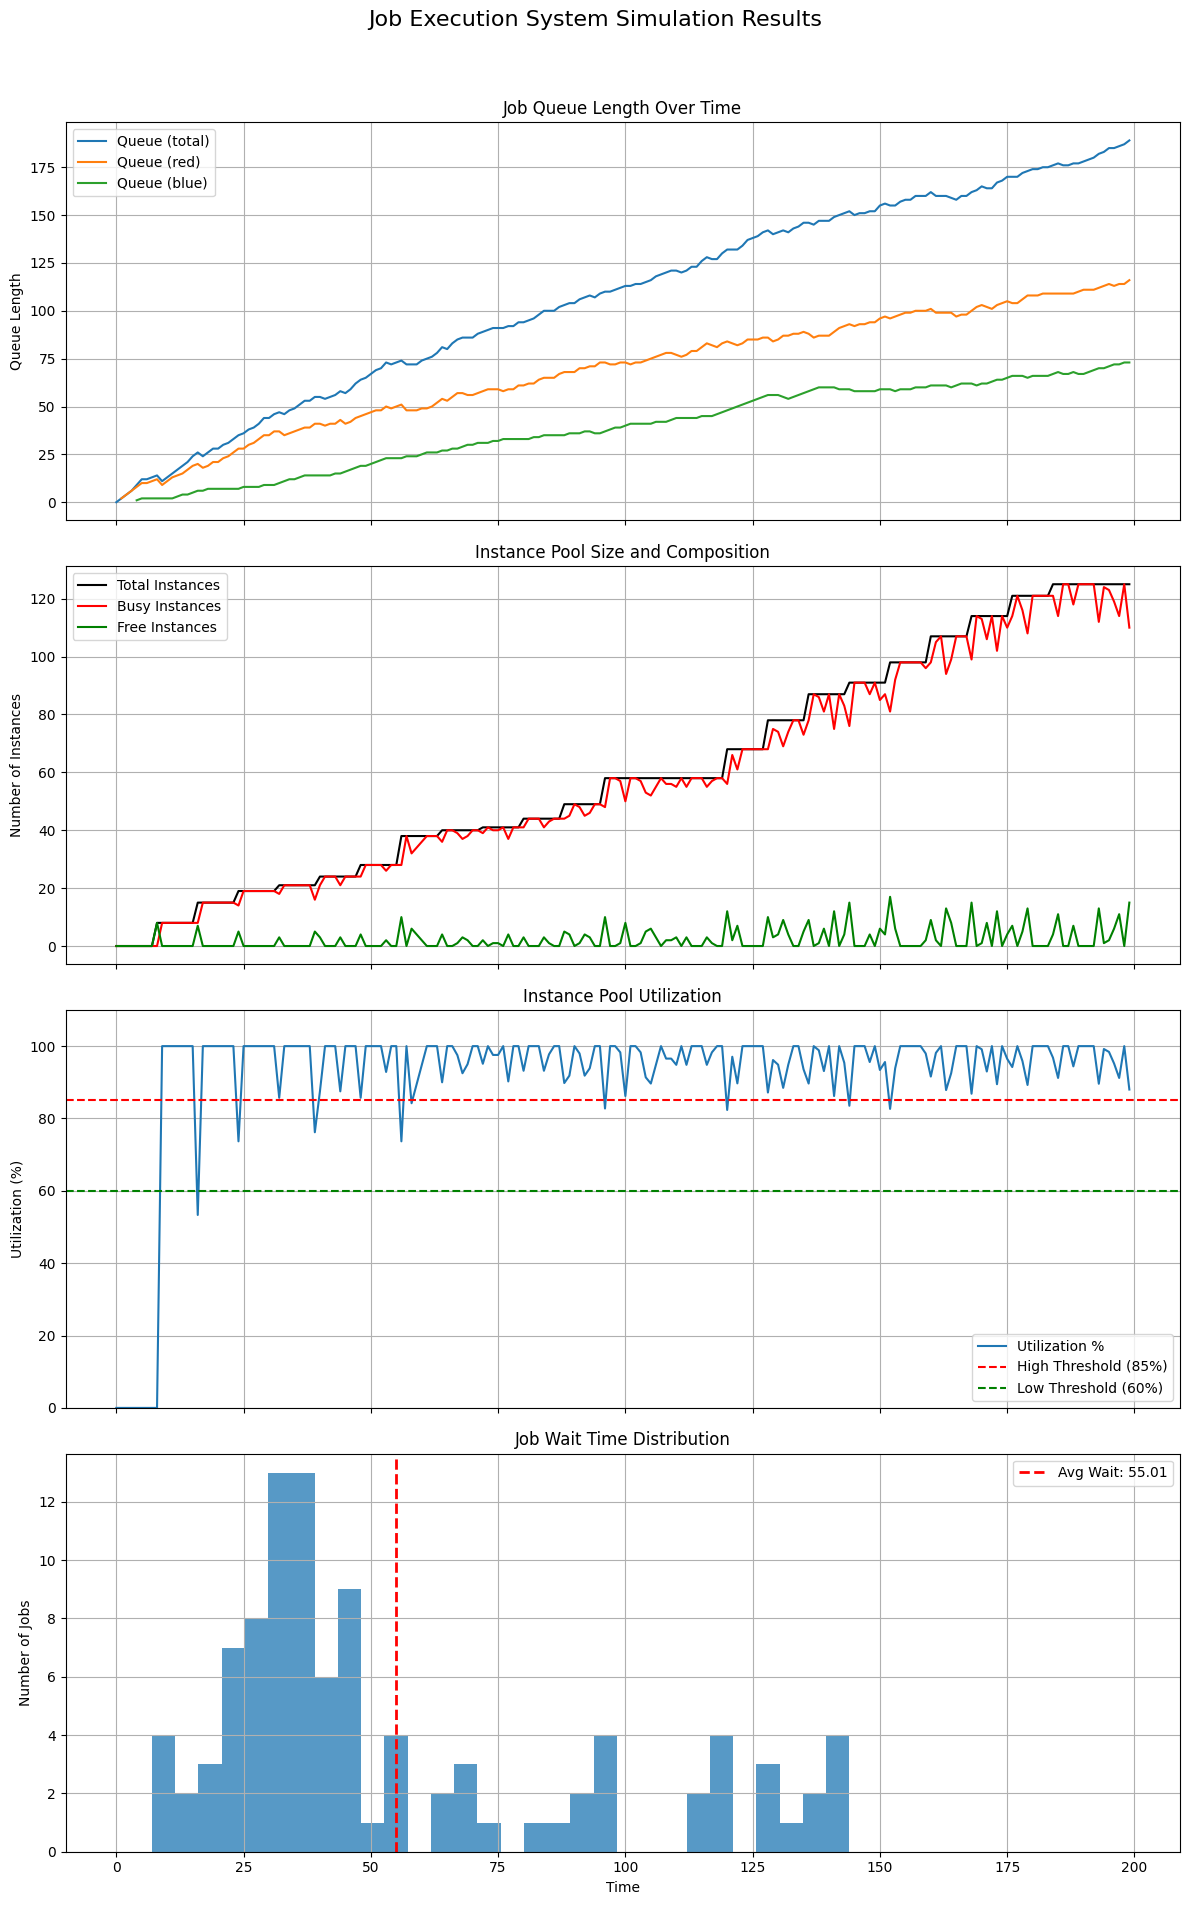

In [6]:
# --- Simulation Parameters ---
SIMULATION_TIME = 200

# --- Run Simulation ---
metrics_reporter = run_simulation(SIMULATION_TIME)

# --- Print Summary and Plot Results ---
metrics_reporter.print_summary()
metrics_reporter.plot()